__Предыдущие разделы__
- Sampling Data

Для упрощения работы и анализа радиолокационных данных существует множество открытых библиотек на github. Однако есть наиболее оконченная такая как ```openradar```. Вся дальнейшая работа основана на наработках данного репозитория.
```python 
!pip install openradar # Библиотека для работы с радаром
import mmwave as mm    # импорт библиотеки для работы с радаром
```
Ссылка на github репозиторий: [OpenRadar on github](https://github.com/PreSenseRadar/OpenRadar)  
Ссылка на докумкентацию модуля: [Welcome to the mmwave docs!](https://openradar.readthedocs.io/en/latest/)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import requests, io

response = requests.get('https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/chirp.txt?raw=true');
response.raise_for_status();
chirp = io.BytesIO(response.content);

# Работа №2

## Введение - пример из жизни

<img src = "https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/radar_blip.jpg?raw=true" alt = "drawing" width = "150" align = 'right'>

В фильмах радары обычно используются для военных целей, таких как обнаружение приближающегося объекта. Офицер наблюдает, как маленькая точка на экране приближается, и необходимо принять решение. Это друг или враг? Что действительно происходит, так это использование радара для определения дальности или определения того, как далеко находится объект относительно радара. Дальность действия - это первая ключевая информация, которая определяется радаром. Однако есть много шагов, которые необходимо предпринять, чтобы обнаружить этот "объект" в поле зрения радаров. Здесь мы только продемонстрируем, как мы можем использовать радар для определения расстояния до "чего-то", которое по иронии судьбы может быть вообще ничем.

## Что видит радар

В данном примере мы хотим знать, как далеко объект находится от радара. Допустим, радар посылает одиночный сигнал, который в конечном итоге (но быстро) отражается от самолета. Затем мы собираем обратное рассеяние этого одиночного сигнала в качестве выборках нашего АЦП. Вся информация, необходимая нам для определения диапазона этого объекта, закодирована в этих образцах данных.

## Обнаружение информации в выборках АЦП

Поскольку каждая из выборок берется через равные промежутки времени, у нас есть запись того, что произошло во время ЛЧМ. Каждый отсчет представляет собой комплексное число, что означает, что мы зафиксировали некоторую величину мощности, а также фазу волны в то время. Таким образом, наш объект теоретически будет отображаться как увеличение мощности в наших выборках. С другой стороны, мы можем использовать различные фазы каждого отсчета для получения расстояния.

- Мощность - $P = \sqrt{I^{2} + Q^{2}}$

- Фаза - $\angle = \arctan{(\frac{I}{Q})}$

($I$ = Мнимая составляющая, $Q$ = Действительная составляющая)

# Вычисление дальности до цели

***



## Шаг 1 - БПФ по дальности

Первым шагом к получению дальности является выполнение БПФ (быстрое преобразование Фурье) по выборкам нашего АЦП для одного ЛЧМ сигнала. Это, к сожалению, не предоставляет нам ни одной дальности. Вместо этого мы получаем несколько "ячеек дальности". Это именно то, на что они похожи, ячейки, в которых хранится информация для различных дальностей. 

Способ получения ячеек дальностей в коде очень прост, нам буквально просто нужно использовать БПФ. Мы можем использовать библиотеку, подобную numpy, для быстрого выполнения этой задачи.

In [ ]:
''' ДАННЫЕ ДЛЯ ПРИМЕРА '''
# Чтение данных ЛЧМ
adc_samples = np.loadtxt(chirp, dtype = np.complex_);

# Приведение к нужному виду данных
adc_samples.real = adc_samples.real.astype(np.int16);
adc_samples.imag = adc_samples.imag.astype(np.int16);

print(f'Размерность ЛЧМ: {adc_samples.size}');

Размерность ЛЧМ: 128


In [ ]:
# Выполнение БПФ по выборкам АЦП
range_bins = np.fft.fft(adc_samples);

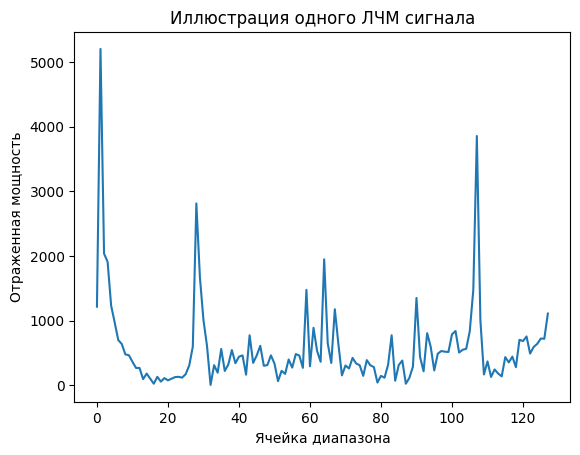

In [ ]:
# Построение графика
plt.plot(np.abs(range_bins));

plt.xlabel('Ячейка диапазона'); 
plt.ylabel('Отраженная мощность'); 
plt.title('Иллюстрация одного ЛЧМ сигнала');

## Шаг 2 - Преобразование единиц измерения

Отлично! Мы успешно интерпретировали данные, полученные радаром. Мы можем четко видеть пики и долины, представляющие возможные объекты, которые может увидеть наш радар. Это важный шаг в использовании наших радиолокационных данных. Мы взяли много сложных образцов, которые кажутся нам бессмысленными, и использовали наши знания для интерпретации формы измерения, которую мы можем понять. Мы уже так много можем сделать с этой информацией.

Но... все еще есть проблема, которую вы, возможно, заметили, каковы единицы измерения? Мой школьный учитель физики сказал бы что-нибудь вроде: "Здесь 256 коров?". Что ж, я не солгал вам, когда сказал, что единицы измерения - это ячейки диапазона, в которых группируются объекты, находящиеся в непосредственной близости. Кроме того, объекты в индексе некоторого диапазона действительно находятся дальше, чем объекты в предыдущем индексе, и ближе, чем объекты в следующем индексе. Однако это, вероятно, то, что вы не хотели слышать. Вы, вероятно, хотели знать в терминах какой-то однозначной единицы измерения, скажем, метров из метрической системы. Чтобы найти единицы измерения в метрах, давайте сначала начнем со следующих уравнений...


- $f = \frac{S2 d}{c}$ - промежуточная частота сигнала, создаваемого одним объектом на расстоянии $d$ (где объект появляется в частотном спектре после диапазона БПФ)
    - $f$ - частота
    - $S$ - крутизна частоты сигнала, излучаемого ЛЧМ
    - $d$ - расстояние относительно радара
    - $c$ - скорость света <br>
- $\Delta f > \frac{1}{T}$ - минимальное расстояние, необходимое в частотном спектре для разрешения радаром <br>
    - $T$ - период дискретизации

Взглянув на первое уравнение, можно увидеть, что существует прямая зависимость между $f$ и $d$...

- $f = \frac{S2 d}{c} \Rightarrow \Delta f = \frac{S2 \Delta d}{c}$

Итак, теперь у нас есть два отдельных уравнения, которые определяют $\Delta f$. Теперь можно использовать замену.

- $\frac{S2 \Delta d}{c} = \Delta f \gt \frac{1}{T}$
- $\frac{S2 \Delta d}{c} \gt \frac{1}{T}$

Наконец, мы можем решить для $\Delta d$, или разрешения по дальности, которого мы можем достичь.

- $\Delta d \gt \frac{c}{2} \cdot \frac{1}{ST}$

Поскольку мы знаем, что $S$ находится в некоторой единице частоты с течением времени, мы можем упростить $ST$ до просто $B$, или полосы пропускания ЛЧМ.

- $\Delta d > \frac{c}{2B}$

Другими словами, разрешение по дальности зависит только от того, насколько большой полосой пропускания обладает чириканье. Давайте посмотрим, какую информацию мы должны использовать, чтобы попытаться найти это разрешение диапазона.

In [ ]:
# ################# # Конфигурация выборки данных
c = 3e8;            # Скорость света (м/с)
sample_rate = 2500; # Скорость, с которой радиолокационные выборки из АЦП (ksps - тысяч выборок (отсчетов) в секунду)
freq_slope = 60;    # Крутизна частоты ЛЧМ (МГц/мкс)
adc_samples = 128;  # Количество выборок (отсчетов) из одного ЛЧМ

Не совсем то, чего мы хотели, но единственное, чего нам не хватает, - это нашей пропускной способности $B$. Мы все еще можем использовать эти параметры для определения полосы пропускания, поскольку это всего лишь диапазон частоты чириканья. Итак, нам просто нужно рассчитать, какую часть частотного диапазона занимает чириканье. Игнорируя пока преобразование единиц измерения, это должно быть нашим уравнением:

- $B = S \cdot \frac{N}{F_s}$
    - $S$ - Крутизна частоты (Частота / время)
    - $N$ - Количество отсчетов АЦП (выборок)
    - $F_s$ - Частота, с которой мы отбираем отсчеты АЦП (отсчеты / время)

In [ ]:
# Вычисление полосы пропускания сигнала ЛЧМ с учетом преобразования единиц измерения
chirp_bandwidth = (freq_slope * 1e12 * adc_samples) / (sample_rate * 1e3);

# Используя наше производное уравнение для разрешения по дальности
range_res = c / (2 * chirp_bandwidth);
print(f'Разрешение по дальности: {range_res} [м]');

# Применение коэффициента разрешения по дальности к индексам дальности
ranges = np.arange(adc_samples) * range_res;
powers = np.abs(range_bins);

Разрешение по дальности: 0.048828125 [м]


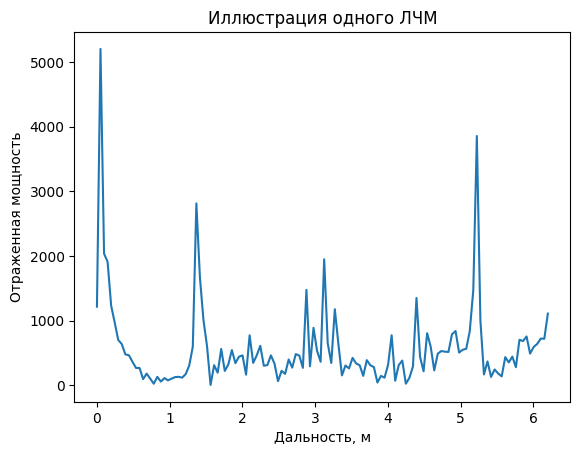

In [ ]:
# Теперь мы можем снова построить график с осью x, которая имеет смысл
plt.plot(ranges, powers);
plt.xlabel('Дальность, м');
plt.ylabel('Отраженная мощность');
plt.title('Иллюстрация одного ЛЧМ');

На этом этапе должно быть ясно, что у нас есть большой контроль над разрешением по дальности. Всего с помощью нескольких настраиваемых параметров мы можем сделать так, чтобы наш радар имел разрешение в несколько сантиметров или несколько метров. С другой стороны, мы можем сделать так, чтобы дальность действия нашего радара составляла несколько метров или сотни метров.

# Обнаружение Постоянного ложного сигнального уровня (CFAR)

***

Одной важной задачей, которую выполняет радиолокационная система, является целевое обнаружение. Само обнаружение является довольно прямым. Это сравнивает сигнал с порогом. Поэтому действительная работа над обнаружением придумывает соответствующий порог. В общем случае порог является функцией и вероятности обнаружения и вероятности ложного предупреждения.

Во многих системах фазированной решетки, из-за стоимости, сопоставленной с ложным обнаружением, желательно иметь порог обнаружения, который не только максимизирует вероятность обнаружения, но также и сохраняет вероятность ложного предупреждения ниже предварительно установленного уровня.

Существует обширная литература по тому, как определить порог обнаружения. Читатели могут интересоваться Обнаружением Сигнала в Белом Гауссовом шуме и Обнаружением Сигнала Используя Несколько Демонстрационных примеров для некоторых известных результатов. Однако все эти классические результаты основаны на теоретических вероятностях и ограничиваются белым Гауссовым шумом с известным отклонением (степень). В действительных приложениях часто окрашивается шум, и его степень неизвестна.

Технология CFAR решает эти проблемы. В CFAR, когда обнаружение необходимо для данной ячейки, которую часто называют как ячейка под тестом (CUT), шумовая мощность оценивается от соседних ячеек. Затем порог обнаружения, T, дают

$$T = \alpha P_n$$

где $P_n$ - оценка шумовой мощности и α масштабный коэффициент, названный пороговым фактором.

От уравнения ясно, что порог адаптируется к данным. Можно показать это с соответствующим пороговым фактором, $\alpha$, получившаяся вероятность ложного предупреждения может быть сохранена в константе, отсюда имя CFAR.

## Ячейка, составляющая в среднем обнаружение CFAR

Ячейка, составляющая в среднем детектор CFAR, является, вероятно, наиболее широко используемым детектором CFAR. Это также используется в качестве базового сравнения для других методов CFAR. В ячейке, составляющей в среднем детектор CFAR, шумовые выборки извлечены и из ведущих и из отстающих ячеек (названный учебными ячейками) вокруг CUT. Шумовая оценка может быть вычислена как

$$P_n = \frac{1}{N}\sum^{N}_{m = 1}{x_m}$$

где $N$ - количество учебных ячеек и $x_m$ выборка в каждой учебной ячейке. Если $x_m$ оказывается, выход квадратичного детектора, затем $P_n$ представляет предполагаемую шумовую мощность. В общем случае количество продвижения и отставания учебных ячеек является тем же самым. Ячейки охраны помещаются смежные с CUT, и продвижение и отставание его. Цель этих защитных ячеек состоит в том, чтобы избежать компонентов сигнала от утечки в учебную ячейку, которая могла оказать негативное влияние на шумовую оценку.

Следующий рисунок показывает отношение среди этих ячеек для 1D случая.

<img src = "https://farm2.staticflickr.com/1652/25170561054_2e4c18a434_z.jpg" alt = "drawing" width = "350" align = 'center'>

С вышеупомянутой ячейкой, составляющей в среднем детектор CFAR, принимая данные, переданные в детектор, от одного импульса, i.e., никакое импульсное интегрирование не включило, пороговый фактор может быть записан как

$$\alpha = N(P_{f\alpha}^{-1/N}-1)$$

где $P_{f\alpha}$ - желаемый ложный сигнальный уровень.

In [ ]:
# TODO: Реализовать функция CFAR
# TODO: peaks_idx = detect_peaks(powers, num_train = 10, num_guard = 2, rate_fa = 0.3);

# TODO: plt.plot(ranges, powers, 'b-', linewidth = 2);
# TODO: plt.plot(ranges[peaks_idx], powers[peaks_idx], 'ro', linewidth = 2);

1. [Detect peaks with CFAR algorithm](https://tsaith.github.io/detect-peaks-with-cfar-algorithm.html)
2. [Обнаружение Постоянного ложного сигнального уровня (CFAR)](https://docs.exponenta.ru/phased/ug/constant-false-alarm-rate-cfar-detection.html)

# Дополнительно
***

## Преимущества радаров миллиметрового диапазона

Радары могут обнаруживать объекты на расстоянии нескольких километров, так почему бы просто не использовать их постоянно? Короче говоря, они были разработаны именно для этого, а это не всегда то, чего вы хотите. Кроме того, поскольку длины волн сигналов намного больше, существует гораздо более грубое разрешение ячеек диапазона. Благодаря радарам с миллиметровыми волнами у нас теперь есть возможность излучать относительно крошечные волны. Это дает нам возможность вести съемку на меньших расстояниях с гораздо большим разрешением.

## Подведение итогов

В этом разделе мы узнали о том, как __радар кодирует__ данные о дальности действия в своих __образцах АЦП__. Существует простой процесс извлечения этой информации, который может быть легко выполнен в коде. В коде мы сначала преобразовали эти данные в единицы, называемые __ячейками диапазона__, выполнив __БПФ по нескольким выборкам АЦП__. Это дискретные относительные расстояния объектов в поле зрения радара. Затем мы нашли __разрешение диапазона__ каждого из этих ячеек диапазона, или диапазон расстояний, на который приходится каждая ячейка. Однако, чтобы найти и рассчитать разрешение данных по дальности, нам нужно было предварительно знать конфигурацию __ЛЧМ__, отправляемого с радара, и конфигурацию выборки. После того, как мы нашли это, мы использовали его для преобразования ячеек диапазона в единицу, с которой мы все знакомы.

## Комментарии

Дальность действия - хорошее начало, но чтобы более четко понять, почему радар широко используется в таких приложениях, как автономные транспортные средства, мы бы рекомендовали изучить еще несколько основ. К ним относятся допплер и угол прибытия (AOA), которые находятся в том же разделе "Основы".

Не показалось ли вам, что в этой записной книжке что-то пропущено? Ну, это потому, что так оно и было. Например, мы на самом деле никогда __не обнаруживали__ этот объект в нашем примере, мы просто создали график, который показал кучу пиков в пределах диапазона. Если вам не терпится, вы можете заглянуть в нашу записную книжку о __CFAR__ и посмотреть, почему нам еще предстоит проделать большую работу. Кроме того, вы, возможно, заметили, что наши участки имеют большой пик мощности на нулевом расстоянии, которое составляет ноль метров. На нулевых метрах ничего не было (кроме радара), на самом деле это своего рода помехи от самого радара. Возможно, вы захотите заглянуть в записную книжку о __Компенсации__, чтобы узнать, как решить эту проблему. Нам еще многое предстоит узнать даже о диапазоне, продолжайте читать!